In [65]:
import pandas as pd
import numpy as np
import glob as glob
from itertools import islice
from sys import argv

In [66]:
!gunzip ../impacc/seqref_truth.chr29.vcf.gz

gzip: ../impacc/seqref_truth.chr29.vcf.gz: No such file or directory


In [67]:
!ls ../impacc/seqref_truth.chr29.vcf

../impacc/seqref_truth.chr29.vcf


In [68]:
true = "../impacc/seqref_truth.chr29.vcf"
imputed = "../impute4_seq_vcf/snp50.chr29.imputed.vcf"

In [69]:
truedict = {}
mafdict ={}
sumdict = {} #Sums number of alternate alleles for parsing with fixed list (missing correlations)
genskey = {'.|.':np.NaN, '0|0':0, '0|1':1, '1|0':1 ,'1|1':2} #phased genskey
with open(true, "r") as t:
    head = list(islice(t,15))
    samples = next(t).strip().split()[9:]
    for line in t:
        splart = line.strip().split()
        cp = (splart[0].strip("Chr"), splart[1])
        pos = ":".join(cp)
        af = float(splart[7].split(';')[2].strip("AF="))
        if af >0.5:
            maf = 1-af
        if af <= 0.5:
            maf = af
        gen = splart[9:]
        x = [i.split(":")[0] for i in gen]
        alt = [genskey[p] for p in x]
        truedict[pos] = alt
        mafdict[pos] = maf
        sumdict[pos] = sum(alt)

In [70]:
mafframe = pd.DataFrame.from_dict(mafdict, orient = 'index') 
mafframe.columns = ['maf']

In [71]:
truedf = pd.DataFrame.from_dict(truedict, orient='index')
truedf.columns = samples

In [38]:
x = truedf.loc[(truedf!=0).any(axis=1)]
nofixed = x.loc[(x!=2).any(axis=1)]

In [72]:
impdict = {} #This dictionary's keys are SNPs, values are lists of counts of alternate alleles for 24 test animals
genskey = {'./.':np.NaN, '0/0':0, '0/1':1, '1/0':1 ,'1/1':2}
with open(imputed, "r") as t:
    head = list(islice(t,7))
    samples = next(t).strip().split()[9:]
    for line in t:
        splat = line.strip().split()
        cp = (splat[0], splat[1])
        pos = ":".join(cp)
        #aflist.append(float(splat[7].split(';')[2].strip("AF=")))
        gen = splat[9:]
        x = [i.split(":")[0] for i in gen]
        alt = [genskey[p] for p in x]
        impdict[pos] = alt

In [73]:
impdf = pd.DataFrame.from_dict(impdict, orient='index')
impdf.columns = samples

In [74]:
correlation = truedf.corrwith(impdf, axis = 1)
cor = pd.DataFrame(correlation)
cor.columns=['correlation']
mafcor = cor.merge(mafframe, left_index=True, right_index=True)


In [57]:
truedf.head() # identify the three potential "problem animals"
problem_samples = ['UMCUSAF000000087089', 'UMCUSAF000000087104', 'UMCUSAF000000087174']
truedf_np = truedf.drop(problem_samples, axis=1)
impdf_np = impdf.drop(problem_samples, axis = 1)

In [58]:
correlation_np = truedf_np.corrwith(impdf_np, axis = 1)
cor_np = pd.DataFrame(correlation_np)
cor_np.columns=['correlation']
mafcor_np = cor_np.merge(mafframe, left_index=True, right_index=True)

In [61]:
mafcor_np.median()

correlation    0.962533
maf            0.004000
dtype: float64

In [62]:
mafcor.median()

correlation    0.844056
maf            0.004000
dtype: float64

In [14]:
mafcor.shape, midaf.shape

((1844156, 2), (117459, 2))

In [16]:
mafcor.describe() # So her we see of the 1.8 million variants, only 290K are able to have imputation acccuracies calculated

,correlation,maf
count,290124.000000,1.844156e+06
mean,0.765435,4.546140e-02
std,0.264698,9.745936e-02
min,-1.000000,0.000000e+00
25%,0.688033,1.000000e-03
50%,0.844056,4.000000e-03
75%,0.951598,3.300000e-02
max,1.000000,5.000000e-01


In [47]:
midaf.sample(10) # Here, 99K of the 117K markers have calculated allele frequencies. 

,correlation,maf
29:28754590,0.619048,0.232
29:11707153,0.691564,0.107
29:12000295,0.933266,0.141
29:37329844,0.853564,0.228
29:42576399,NaN,0.101
29:42593385,0.767812,0.171
29:39153667,0.781925,0.193
29:35785524,0.567282,0.210
29:29039995,1.000000,0.142
29:39268875,0.043478,0.107


In [52]:
truedict['29:39153667']

[0, 1, 1, 2, 2, 1, 2, 1, 2, 0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2]

In [53]:
impdict['29:39153667']

[0, 1, 1, 2, 2, 0, 2, 1, 2, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]

In [31]:
(21/24)/(3/24)

7.0

In [13]:
midaf = mafcor[(mafcor['maf'] >= 0.1) & (mafcor['maf'] <= 0.25)]

In [40]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import glob as glob
plt.style.use('fivethirtyeight')

label = {'color':  'black',
		'weight': 'normal',
		'size': 10,
		}
title = {'color':  'black',
		'weight': 'normal',
		'size': 12,
		}

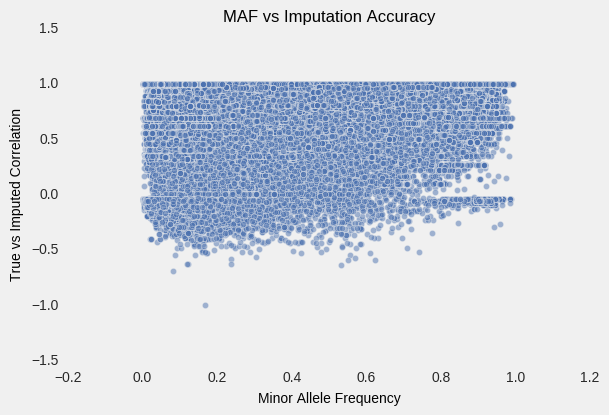

In [35]:
mafsp = mafcor.plot.scatter(x = "maf", y = "correlation", alpha = 0.5)
#name = corr.strip(".snp_correlations.csv").strip("/imp_acc/")
mafsp.set_xlabel('Minor Allele Frequency', fontdict=label)
mafsp.set_ylabel('True vs Imputed Correlation', fontdict=label)
mafsp.set_title("MAF vs Imputation Accuracy", fontdict=title)
mafsp.grid(False)
fig = mafsp.get_figure()

In [54]:
notfixed = mafcor''[mafcor.correlation.notnull()&mafcor.maf.notnull()]

In [64]:
truedict['29:39598257'] #imputation accuracy:0.5065020 MAF =.500

[1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2]

In [65]:
impdict['29:39598257']

[1, 2, 1, 2, 2, 0, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1]

In [66]:
truedict['29:33955939'] #imputation accuracy: 1.0 MAF =.0.001

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [67]:
impdict['29:33955939']

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
notfixed.sort_values(['correlation']).head()

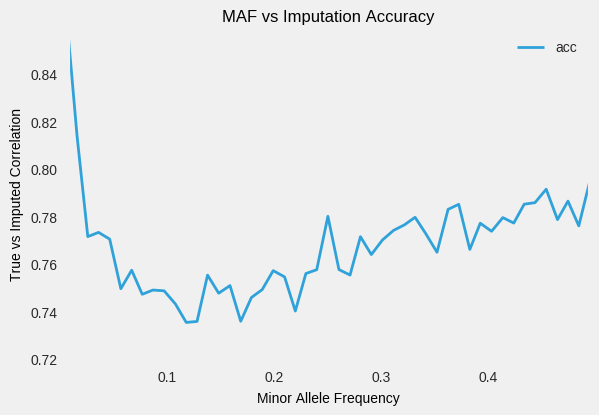

In [56]:
maf = notfixed['maf']
plotter = pd.DataFrame(maf)
plotter["acc"] = notfixed["correlation"]
bins = np.linspace(0,.5,50)
plotter_na = plotter[(-2<plotter['acc']) & (plotter['acc']<2)]
#print (plotter_na.describe())
a_bins = plotter_na.groupby(pd.cut(plotter_na['maf'],bins))
mean_bin = a_bins.mean()
del mean_bin.index.name

mafline = a_bins.mean().plot(x='maf',y='acc', linewidth=2.0)
#name = corr.strip(".snp_correlations.csv").strip("/imp_acc/")
mafline.set_xlabel('Minor Allele Frequency', fontdict=label)
mafline.set_ylabel('True vs Imputed Correlation', fontdict=label)
mafline.set_title("MAF vs Imputation Accuracy",fontdict=title)
mafline.grid(False)
fig = mafline.get_figure()

In [49]:
maf = mafcor['maf']
plotter = pd.DataFrame(maf)
plotter["acc"] = mafcor["correlation"]
bins = np.linspace(0,.5,50)
plotter_na = plotter[(-2<plotter['acc']) & (plotter['acc']<2)]
#print (plotter_na.describe())
a_bins = plotter_na.groupby(pd.cut(plotter_na['maf'],bins))
mean_bin = a_bins.mean()
del mean_bin.index.name

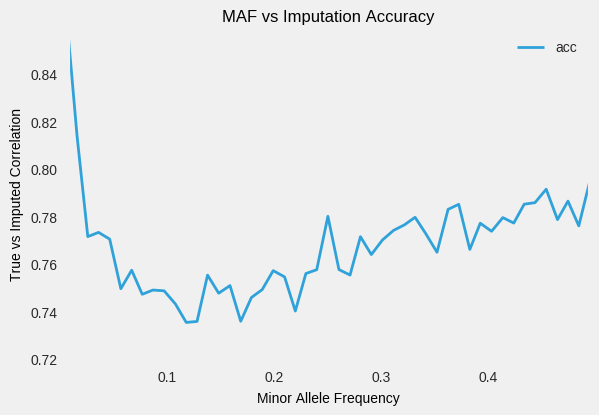

In [50]:
mafline = a_bins.mean().plot(x='maf',y='acc', linewidth=2.0)
#name = corr.strip(".snp_correlations.csv").strip("/imp_acc/")
mafline.set_xlabel('Minor Allele Frequency', fontdict=label)
mafline.set_ylabel('True vs Imputed Correlation', fontdict=label)
mafline.set_title("MAF vs Imputation Accuracy",fontdict=title)
mafline.grid(False)
fig = mafline.get_figure()

In [ ]:
fixed_snps = list(fixed.index) # These are the SNPs that are fixed in both imputation AND test sets (give a correlation of NaN)

In [ ]:
#This loop goes through fixed_snps list and checks to see if they are not fixed (theoretically sum of alt alleles should be 0, 24, or 48 for the fixed SNPs)
problem_snps = []
for xx in fixed_snps:
    if sumdict[xx] != 0 and sumdict[xx] !=24 and sumdict[xx] != 48:
        problem_snps.append(xx)

In [ ]:
mafcor.describe()

In [ ]:
mafcorfull = mafcor.fillna(1).drop(problem_snps)
mafcorfull.describe()

In [ ]:
mafcorfull.index.name = 'mrk_id'

In [ ]:
mafcorfull['snp_name'] = mafcorfull.index

In [ ]:
mafcorfull.head()

In [ ]:
mafcorfull[['chr', 'pos']] = mafcorfull['snp_name'].str.split(':', expand=True)

In [ ]:
mafcorfull.drop(['snp_name'], axis=1).head()

In [1]:
corr = "./hd.chr29.snp_correlations.csv"

In [2]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
!head ./hd.chr29.snp_correlations.csv

mrk_id,imputation_accuracy,maf,snp_name,chr,pos
29:10000022,1.0,0.001,29:10000022,29,10000022
29:10000061,1.0,0.001,29:10000061,29,10000061
29:1000010,1.0,0.0,29:1000010,29,1000010
29:10000105,0.6741998624632421,0.057,29:10000105,29,10000105
29:10000117,1.0,0.003,29:10000117,29,10000117
29:10000133,1.0,0.001,29:10000133,29,10000133
29:10000195,1.0,0.001,29:10000195,29,10000195
29:10000211,0.713024095907381,0.294,29:10000211,29,10000211
29:10000229,1.0,0.006,29:10000229,29,10000229


In [4]:
cor = pd.DataFrame.from_csv(corr)

In [7]:
label = {'color':  'black',
		'weight': 'normal',
		'size': 10,
		}
title = {'color':  'black',
		'weight': 'normal',
		'size': 12,
		}

In [ ]:
mean = str(cor.mean()[0])

In [ ]:
hg = cor.imputation_accuracy.plot.hist(bins = 100)
name = corr.strip(".snp_correlations.csv").strip("/imp_acc/")
hg.set_xlabel('True vs Imputed Correlation', fontdict=label)
hg.set_ylabel('Count', fontdict=label)
hg.grid(False)
hg.set_title("Histogram of Imputation Correlations per Locus\n" + name + '\nMean Correlation = ' + mean, fontdict=title)
fig = hg.get_figure()

In [ ]:
mafsp = mafcor.plot.scatter(x = "maf", y = "imputation_accuracy", alpha = 0.5)
name = corr.strip(".snp_correlations.csv").strip("/imp_acc/")
mafsp.set_xlabel('Minor Allele Frequency', fontdict=label)
mafsp.set_ylabel('True vs Imputed Correlation', fontdict=label)
mafsp.set_title("MAF vs Imputation Accuracy\n"+name, fontdict=title)
mafsp.grid(False)
fig = mafsp.get_figure()

In [29]:
impdict['29:10078601']

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [30]:
truedict['29:10078601']

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [35]:
cor.loc['29:10078601']

correlation   NaN
Name: 29:10078601, dtype: float64

In [68]:
cor.notnull().sum()

0    290124
dtype: int64

In [69]:
cor.mean()

0    0.765435
dtype: float64

In [70]:
cor.isnull().sum()

0    1554157
dtype: int64

In [71]:
(290124*0.765435 + 1554157)/len(cor) # SNP50 only imputation accuracy

0.9631005600231202

In [59]:
(300761*0.83256 + 1544568)/len(cor) # HD only imputation accuracy

0.972709786796826

In [58]:
len(cor)

1845329

In [38]:
cor.mean()

0    0.83256
dtype: float64

In [19]:
truedict['29:33']

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [20]:
impdict['29:33']

[0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [23]:
!head -n 18 ../impacc/seqref_truth.chr29.vcf

##fileformat=VCFv4.1
##FILTER=<ID=PASS,Description="All filters passed">
##filedate=20170226
##source="beagle.jar (r1399)"
##INFO=<ID=AF,Number=A,Type=Float,Description="Estimated Allele Frequencies">
##INFO=<ID=AR2,Number=1,Type=Float,Description="Allelic R-Squared: estimated correlation between most probable ALT dose and true ALT dose">
##INFO=<ID=DR2,Number=1,Type=Float,Description="Dosage R-Squared: estimated correlation between estimated ALT dose [P(RA) + 2*P(AA)] and true ALT dose">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=DS,Number=1,Type=Float,Description="estimated ALT dose [P(RA) + P(AA)]">
##FORMAT=<ID=GP,Number=G,Type=Float,Description="Estimated Genotype Probability">
##contig=<ID=Chr29>
##INFO=<ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes">
##INFO=<ID=AN,Number=1,Type=Integer,Description="Total number of alleles in called genotypes">
##bcftools_viewVersion=1.2+htslib-1.2.1
##bcftools_viewCommand=view -S dataprepper/br

In [21]:
!head -n 10 ../impute4_seq_vcf/snp50.chr29.imputed.vcf

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=GP,Number=G,Type=Float,Description="Genotype Probabilities">
##contig=<ID=29,length=2147483647>
##bcftools_convertVersion=1.2+htslib-1.2.1
##bcftools_convertCommand=convert -G impute4_seq_chromosome/snp50.chr29.gen -o impute4_seq_vcf/snp50.chr29.imputed.vcf
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	UMCUSAM000000078648	UMCUSAF000000078757	UMCUSAF000000078773	UMCUSAF000000078827	UMCUSAM000000078836	UMCUSAM000000078853	UMCUSAF000000079050	UMCUSAM000000079160	UMCUSAM000000079488	UMCUSAM000000079863	UMCUSAF000000080134	UMCUSAF000000080421	UMCUSAU000000082366	UMCUSAF000000086883	UMCUSAF000000086953	UMCUSAF000000086954	UMCUSAF000000086956	UMCUSAF000000087024	UMCUSAF000000087089	UMCUSAF000000087104	UMCUSAF000000087174	UMCUSAF000000087309	UMCUSAF000000087335	UMCUSAF000000087398
29	11	.	C	T	.	.	.	GT:GP	0/0:0.869,0.13,0.001	0/0:0.866,0.129,0.004	0/

In [29]:
cor.loc['29:11']

0   -0.062869
Name: 29:11, dtype: float64